In [1]:
#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_graphviz
import xgboost as xgb
from xgboost import plot_tree
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import ttest_ind
from scipy import stats
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

# for Mac errors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# for graphs
def format_dollars(y, pos):
    return '{:,.0f}'.format(y)

**Data Preprocessing in team7-Final.ipynb**

Note: columns of `cbsa` were not encoded or split beforehand. Columns were from the original dataset in addition to the predicted values from the Gamma Regression

In [3]:
# load data
cbsa = pd.read_csv("cbsa2.csv")
cbsa.head()

,number_of_providers,zone,in_range
0,3.0,central,True
1,18.0,pacific,True
2,11.0,central,True
3,5.0,central,True
4,18.0,eastern,True


In [4]:
cbsa.shape

(162848, 3)

In [5]:
tf_counts = cbsa['in_range'].value_counts()
tf_counts

in_range
True     162387
False       461
Name: count, dtype: int64

**Baseline Model to compare**

In [6]:
cbsa['in_range'].value_counts()[0]

162387

In [7]:
(cbsa['in_range'].value_counts()[0]/cbsa.shape[0])*100

99.71691393201021

After rebalancing, the model would have 99.7% accuracy rate because 99.7% of samples in our model are not in range (False). The models built need to be more than 99.7% accurate in order to be informative (ADS 502 presentation).

**Split Data**

In [8]:
# split data
cbsa_train, cbsa_test = train_test_split(cbsa,
                                            test_size = 0.25,
                                            random_state = 7)

In [9]:
print('Original shape before partition: ', cbsa.shape[0],
        '\nTraining set shape: ', cbsa_train.shape[0],
        '\nTest set shape: ', cbsa_test.shape[0])

Original shape before partition:  162848 
Training set shape:  122136 
Test set shape:  40712


In [10]:
print('Proportion of training instances: ', cbsa_train.shape[0]/cbsa.shape[0]*100,
        '\nProportion of test instances: ', cbsa_test.shape[0]/cbsa.shape[0]*100)

Proportion of training instances:  75.0 
Proportion of test instances:  25.0


**Validate proportions**

In [11]:
train_mean = cbsa_train['number_of_providers']

In [12]:
test_mean = cbsa_test['number_of_providers']

In [13]:
t_statistic, p_value = stats.ttest_ind(train_mean, test_mean)
print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.2873130263378106
p-value: 0.7738730149568552


In [14]:
stats.ttest_ind(cbsa_train['in_range'], cbsa_test['in_range'])

TtestResult(statistic=0.08078357932460514, pvalue=0.935614166458079, df=162846.0)

P-value is not less than 0.05; therefore, there is no statistically significant difference in the partitions. The splits are valid.

Balance Training Dataset

In [15]:
# response variable
cbsa_train['in_range'].value_counts()

in_range
True     121791
False       345
Name: count, dtype: int64

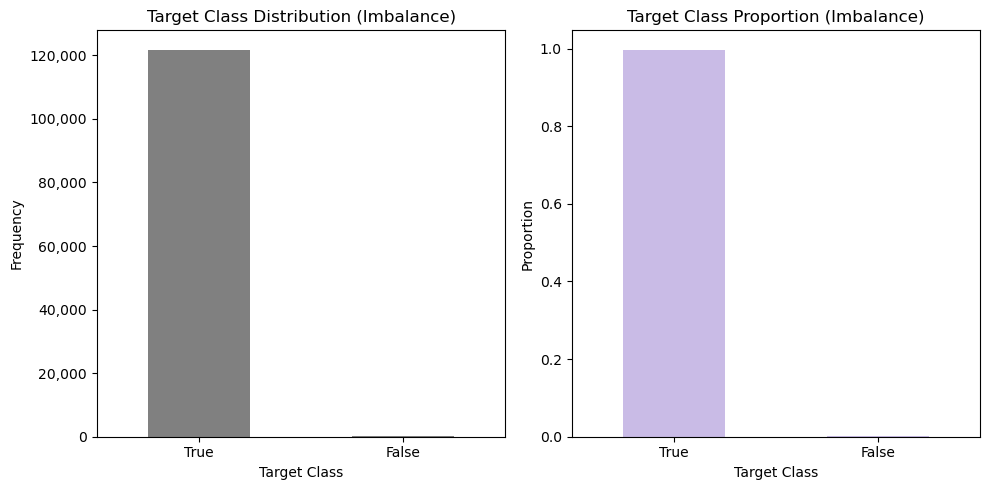

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# target class frequency
cbsa_train['in_range'].value_counts().plot(kind='bar', color='gray', ax=axes[0])
axes[0].set_title('Target Class Distribution (Imbalance)')
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=0)

formatter = ticker.FuncFormatter(format_dollars)
axes[0].yaxis.set_major_formatter(formatter)

# proportion of target class
value_counts = cbsa_train['in_range'].value_counts()
proportions = value_counts / value_counts.sum()
proportions.plot(kind='bar', color='#c9bbe6', ax=axes[1])
axes[1].set_title('Target Class Proportion (Imbalance)')
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Calculate ratio of minority class and find out how many to increase to get 30%**

In [17]:
# instances of minority divide by total instances
ratio = cbsa_train['in_range'].value_counts()[1] / cbsa_train.shape[0]*100
ratio

0.28247199842798193

imbalanced at 0.28%. False response will change depending on partition. Increase False response to 30%. For p(False) = 0.3, it needs X records to resample. Then, add to training set.

In [18]:
# isolate records to resample
to_resample = cbsa_train.loc[cbsa_train['in_range'] == False]
to_resample.shape[0]

345

In [19]:
cbsa_train.shape[0]

122136

In [20]:
p = 0.3
n = round(((p*cbsa_train.shape[0]) - to_resample.shape[0])/(1-p),0)
print(n)

51851.0


**Sample with replacement with 51851 records from the `False` class**

In [21]:
# sample from recods of interest
our_sample = to_resample.sample(n = int(n), replace = True)

In [22]:
# add sample to original training set
cbsa_train_rebal = pd.concat([cbsa_train, our_sample], axis = 0)

In [23]:
cbsa_train_rebal['in_range'].value_counts()

in_range
True     121791
False     52196
Name: count, dtype: int64

In [24]:
# confirm desiered % increase
ratio = cbsa_train_rebal['in_range'].value_counts()[1]/cbsa_train_rebal.shape[0]*100
ratio

29.99994252444148

In [25]:
cbsa_train_rebal.shape

(173987, 3)

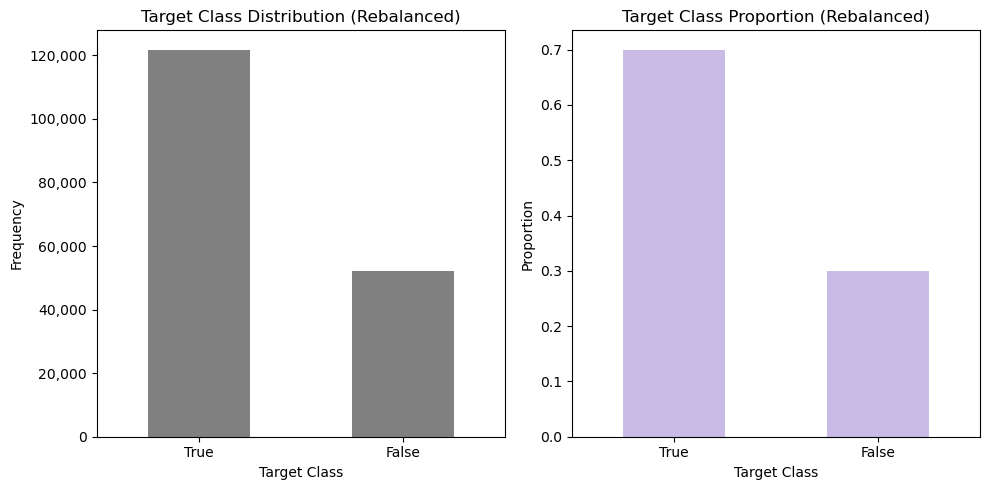

In [26]:
# visualize proportion of rebalance
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# target class frequency
cbsa_train_rebal['in_range'].value_counts().plot(kind='bar', color='gray', ax=axes[0])
axes[0].set_title('Target Class Distribution (Rebalanced)')
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=0)

formatter = ticker.FuncFormatter(format_dollars)
axes[0].yaxis.set_major_formatter(formatter)

# proportion of target class
value_counts = cbsa_train_rebal['in_range'].value_counts()
proportions = value_counts / value_counts.sum()
proportions.plot(kind='bar', color='#c9bbe6', ax=axes[1])
axes[1].set_title('Target Class Proportion (Rebalanced)')
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Proportion')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

**Modeling**

In [27]:
# metrics function
def calculate_metrics(model, TN, FP, FN, TP):
    # calculations
    TPN = TN + FN
    TPP = FP + TP
    TAN = TN + FP
    TAP = FN + TP
    GT = TN + FN + FP + TP
    
    accuracy = ((TN+TP)/GT)
    error_rate = 1 - accuracy
    sensitivity = TP/TAP
    specificity = TN/TAN
    precision = TP/TPP
    recall = sensitivity
    F1 = 2 * ((precision*recall)/(precision+recall))
    F2 = 5 * ((precision*recall)/((4*precision)+recall))
    F05 = 1.25 * ((precision*recall)/((0.25*precision)+recall))

    # Create a DataFrame with metric values
    values_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Error Rate', 'Sensitivity', 'Specificity', 
                   'Precision', 'Recall', 'F1 Score', 'F2 Score', 'F0.5 Score'],
        f'{model} Values': [accuracy, error_rate, sensitivity, specificity, 
                            precision, recall, F1, F2, F05]
    })

    return values_df

In [28]:
# split predictor and target variables into separate objects
X_train = cbsa_train_rebal.drop(['in_range'], axis=1)
y_train = cbsa_train_rebal['in_range']
X_train.head()

,number_of_providers,zone
65549,91.0,eastern
125888,12.0,pacific
83150,61.0,central
109998,9.0,eastern
110434,5.0,central


**Encode categoricals in training set**

In [29]:
X_train_numerical = X_train['number_of_providers']

In [30]:
train_encoded = pd.get_dummies(X_train['zone'])
train_encoded = train_encoded.astype(int)

# concatenate with rest of predictors
X_train = pd.concat([X_train_numerical, train_encoded], axis=1)
X_train

,number_of_providers,alaska,atlantic,central,eastern,hawaii,mountain,pacific
65549,91.0,0,0,0,1,0,0,0
125888,12.0,0,0,0,0,0,0,1
83150,61.0,0,0,1,0,0,0,0
109998,9.0,0,0,0,1,0,0,0
110434,5.0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
16726,296.0,0,0,0,1,0,0,0
41051,75.0,0,0,0,0,0,0,1
125188,158.0,0,0,0,1,0,0,0
77314,75.0,0,0,0,0,0,0,1


**Train Model**

In [31]:
# train NB model using by passing predictor and target training
nb = MultinomialNB().fit(X_train, y_train)

**Encode categoricals in test set**

In [32]:
X_test = cbsa_test.drop(['in_range'], axis=1)
y_test = cbsa_test['in_range']

In [33]:
X_test_numerical = X_test['number_of_providers']

In [34]:
test_encoded = pd.get_dummies(X_test['zone'])
test_encoded = test_encoded.astype(int)

X_test = pd.concat([X_test_numerical, test_encoded], axis=1)

In [35]:
# make prediction on test set using nb model
nb_preds = nb.predict(X_test)

**Confusion Matrix**

In [36]:
nb_cm =confusion_matrix(y_test, nb_preds)

In [37]:
nb_cm

array([[   39,    77],
       [ 1704, 38892]], dtype=int64)

In [38]:
TN = nb_cm[0][0]
FP = nb_cm[0][1]
FN = nb_cm[1][0]
TP = nb_cm[1][1]

nb_metrics = calculate_metrics("nb1", TN, FP, FN, TP)
nb_metrics

,Metric,nb1 Values
0,Accuracy,0.956254
1,Error Rate,0.043746
2,Sensitivity,0.958025
3,Specificity,0.336207
4,Precision,0.998024
5,Recall,0.958025
6,F1 Score,0.977616
7,F2 Score,0.965767
8,F0.5 Score,0.989759


**Baseline Logistic Regression**

Goal: determine wether or not cbsa are in range for average total payment per user.

In [39]:
# add constant to rebalanced
X_1 = sm.add_constant(X_train)

In [40]:
# logistic regression with manual rebalanced samples
logreg01 = sm.Logit(y_train, X_1).fit()
logreg01.summary2()

         Current function value: 0.473667
         Iterations: 35


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: Logit
=====================================================================================
Model:                     Logit                  Method:                 MLE        
Dependent Variable:        in_range               Pseudo R-squared:       0.225      
Date:                      2024-04-15 17:29       AIC:                    164839.7594
No. Observations:          173987                 BIC:                    164920.2933
Df Model:                  7                      Log-Likelihood:         -82412.    
Df Residuals:              173979                 LL-Null:                -1.0628e+05
Converged:                 0.0000                 LLR p-value:            0.0000     
No. Iterations:            35.0000                Scale:                  1.0000     
-------------------------------------------------------------------------------------
                     Coef.     Std.Err.       z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------------------
const                17.4245          nan       nan    nan           nan          nan
number_of_providers  -0.0077       0.0001 -135.5444 0.0000       -0.0079      -0.0076
alaska               11.4391          nan       nan    nan           nan          nan
atlantic             12.8089          nan       nan    nan           nan          nan
central             -15.4839          nan       nan    nan           nan          nan
eastern             -16.0660          nan       nan    nan           nan          nan
hawaii               19.8613 3851809.9027    0.0000 1.0000 -7549388.8233 7549428.5459
mountain             20.9803          nan       nan    nan           nan          nan
pacific             -16.1152          nan       nan    nan           nan          nan
=====================================================================================

"""

**Validate Model**

In [41]:
X_test1 = sm.add_constant(X_test)
logreg01_test = sm.Logit(y_test, X_test1).fit()
logreg01_test.summary2()

         Current function value: 0.018569
         Iterations: 35


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
==================================================================================
Model:                     Logit                 Method:                MLE       
Dependent Variable:        in_range              Pseudo R-squared:      0.050     
Date:                      2024-04-15 17:29      AIC:                   1527.9412 
No. Observations:          40712                 BIC:                   1596.8555 
Df Model:                  7                     Log-Likelihood:        -755.97   
Df Residuals:              40704                 LL-Null:               -795.67   
Converged:                 0.0000                LLR p-value:           1.8192e-14
No. Iterations:            35.0000               Scale:                 1.0000    
----------------------------------------------------------------------------------
                     Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
----------------------------------------------------------------------------------
const               13.8679 2741263.5784  0.0000 1.0000 -5372764.0179 5372791.7537
number_of_providers -0.0005       0.0001 -6.6766 0.0000       -0.0006      -0.0003
alaska              11.5456 2741374.7899  0.0000 1.0000 -5372984.3106 5373007.4019
atlantic            10.5497 2741284.1835  0.0000 1.0000 -5372807.7214 5372828.8208
central             -7.5848 2741263.5784 -0.0000 1.0000 -5372785.4706 5372770.3010
eastern             -8.1821 2741263.5784 -0.0000 1.0000 -5372786.0680 5372769.7037
hawaii               8.4529 2741269.5997  0.0000 1.0000 -5372781.2344 5372798.1403
mountain             7.7365 2741263.7193  0.0000 1.0000 -5372770.4254 5372785.8984
pacific             -8.6500 2741263.5784 -0.0000 1.0000 -5372786.5358 5372769.2358
==================================================================================

"""

Another way to validate the logistic regression model is to evaluate the ROC curve which shows how well a classification model can distinguish between the two classes (e.g., positive and negative) by plotting the rate of correct predictions (true positives) against the rate of incorrect predictions (false positives) at different decision thresholds.

**Model 1: LogisticRegression**

In [42]:
logreg01 = LogisticRegression()
logreg01.fit(X_train, y_train)
logreg01_preds = logreg01.predict(X_test)

logreg01_cm =confusion_matrix(y_test, logreg01_preds)
logreg01_cm

array([[   32,    84],
       [ 1506, 39090]], dtype=int64)

In [43]:
TN = logreg01_cm[0][0]
FP = logreg01_cm[0][1]
FN = logreg01_cm[1][0]
TP = logreg01_cm[1][1]

logreg01_cm_metrics = calculate_metrics("LogReg", TN, FP, FN, TP)
logreg01_cm_metrics

,Metric,LogReg Values
0,Accuracy,0.960945
1,Error Rate,0.039055
2,Sensitivity,0.962903
3,Specificity,0.275862
4,Precision,0.997856
5,Recall,0.962903
6,F1 Score,0.980068
7,F2 Score,0.969696
8,F0.5 Score,0.990664


**Model 2: XGBoost**

In [44]:
# Train XGBoost classifier
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, xgb_preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.29%


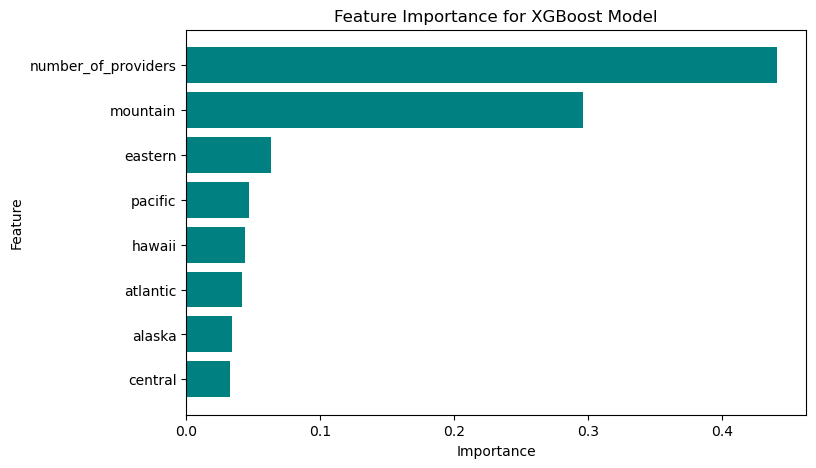

In [45]:
feature_importance = xgb_model.feature_importances_

# y-axis labels
feature_names = X_train.columns

# DataFrame with feature importance dict
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importance
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [46]:
xgb_cm =confusion_matrix(y_test, xgb_preds)
xgb_cm

array([[   95,    21],
       [ 2709, 37887]], dtype=int64)

In [47]:
TN = xgb_cm[0][0]
FP = xgb_cm[0][1]
FN = xgb_cm[1][0]
TP = xgb_cm[1][1]

xgb_metrics = calculate_metrics("XGBoost", TN, FP, FN, TP)
xgb_metrics

,Metric,XGBoost Values
0,Accuracy,0.932944
1,Error Rate,0.067056
2,Sensitivity,0.933269
3,Specificity,0.818966
4,Precision,0.999446
5,Recall,0.933269
6,F1 Score,0.965225
7,F2 Score,0.945794
8,F0.5 Score,0.985470


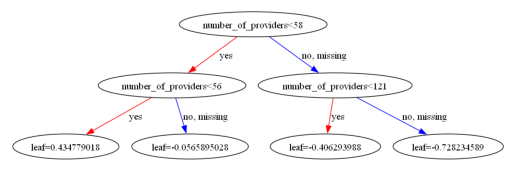

In [48]:
# visualize trees by XGBoost
params = {'objective': 'binary:logistic', 'max_depth': 2}

# Train the XGBoost model
bst = xgb.train(params, dtrain=xgb.DMatrix(X_train, label=y_train), num_boost_round=10)
# xgb.to_graphviz(bst, num_trees=0).render('tree_graph10', format='png')
# first tree
plot_tree(bst, num_trees=0)
plt.show()

In [49]:
# binary classification interpret leaf negative 
print("the probability of this data point being class 1 is", 1/(1+ np.exp(-(0.0820540711))))

the probability of this data point being class 1 is 0.5205020159472694


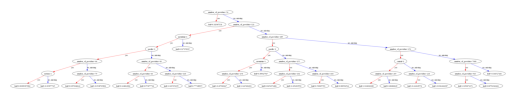

In [50]:
xgb.plot_tree(xgb_model, num_trees=4)
# xgb.to_graphviz(xgb_model, num_trees=4).render('tree_graph11', format='png')
plt.show()

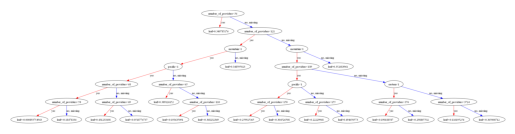

In [51]:
model_xgbcolor = xgb.XGBClassifier(**params)
params = {
    'max_depth': 6,
    'min_child_weight': 6,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
model_xgbcolor = xgb.XGBClassifier(**params)

model_xgbcolor.fit(X_train, y_train)

model_xgbcolor_preds = model_xgbcolor.predict(X_test)

xgb.plot_tree(model_xgbcolor, num_trees=4, node_colors='#7FFF00')
# xgb.to_graphviz(xgb_model, num_trees=4).render('tree_graph11', format='png')
plt.show()

In [52]:
model_xgbcolor =confusion_matrix(y_test, model_xgbcolor_preds)

TN = model_xgbcolor[0][0]
FP = model_xgbcolor[0][1]
FN = model_xgbcolor[1][0]
TP = model_xgbcolor[1][1]

xgbcolor_metrics = calculate_metrics("XGBoostColor", TN, FP, FN, TP)
xgbcolor_metrics

,Metric,XGBoostColor Values
0,Accuracy,0.933386
1,Error Rate,0.066614
2,Sensitivity,0.933590
3,Specificity,0.862069
4,Precision,0.999578
5,Recall,0.933590
6,F1 Score,0.965458
7,F2 Score,0.946081
8,F0.5 Score,0.985644


In [53]:
# build C5.0 model with a minimum of 5 cases per terminal node
c50_01 = DecisionTreeClassifier(
    criterion="entropy", max_leaf_nodes=5).fit(X_train, y_train)

# export summary of C5.0 tree
# export_graphviz(c50_01, out_file = "c50.txt", feature_names=X_names, class_names=y_names)

In [54]:
c5_preds = c50_01.predict(X_test)

In [55]:
classes = cbsa['in_range'].unique().tolist()
classes_as_strings = [str(x) for x in classes]

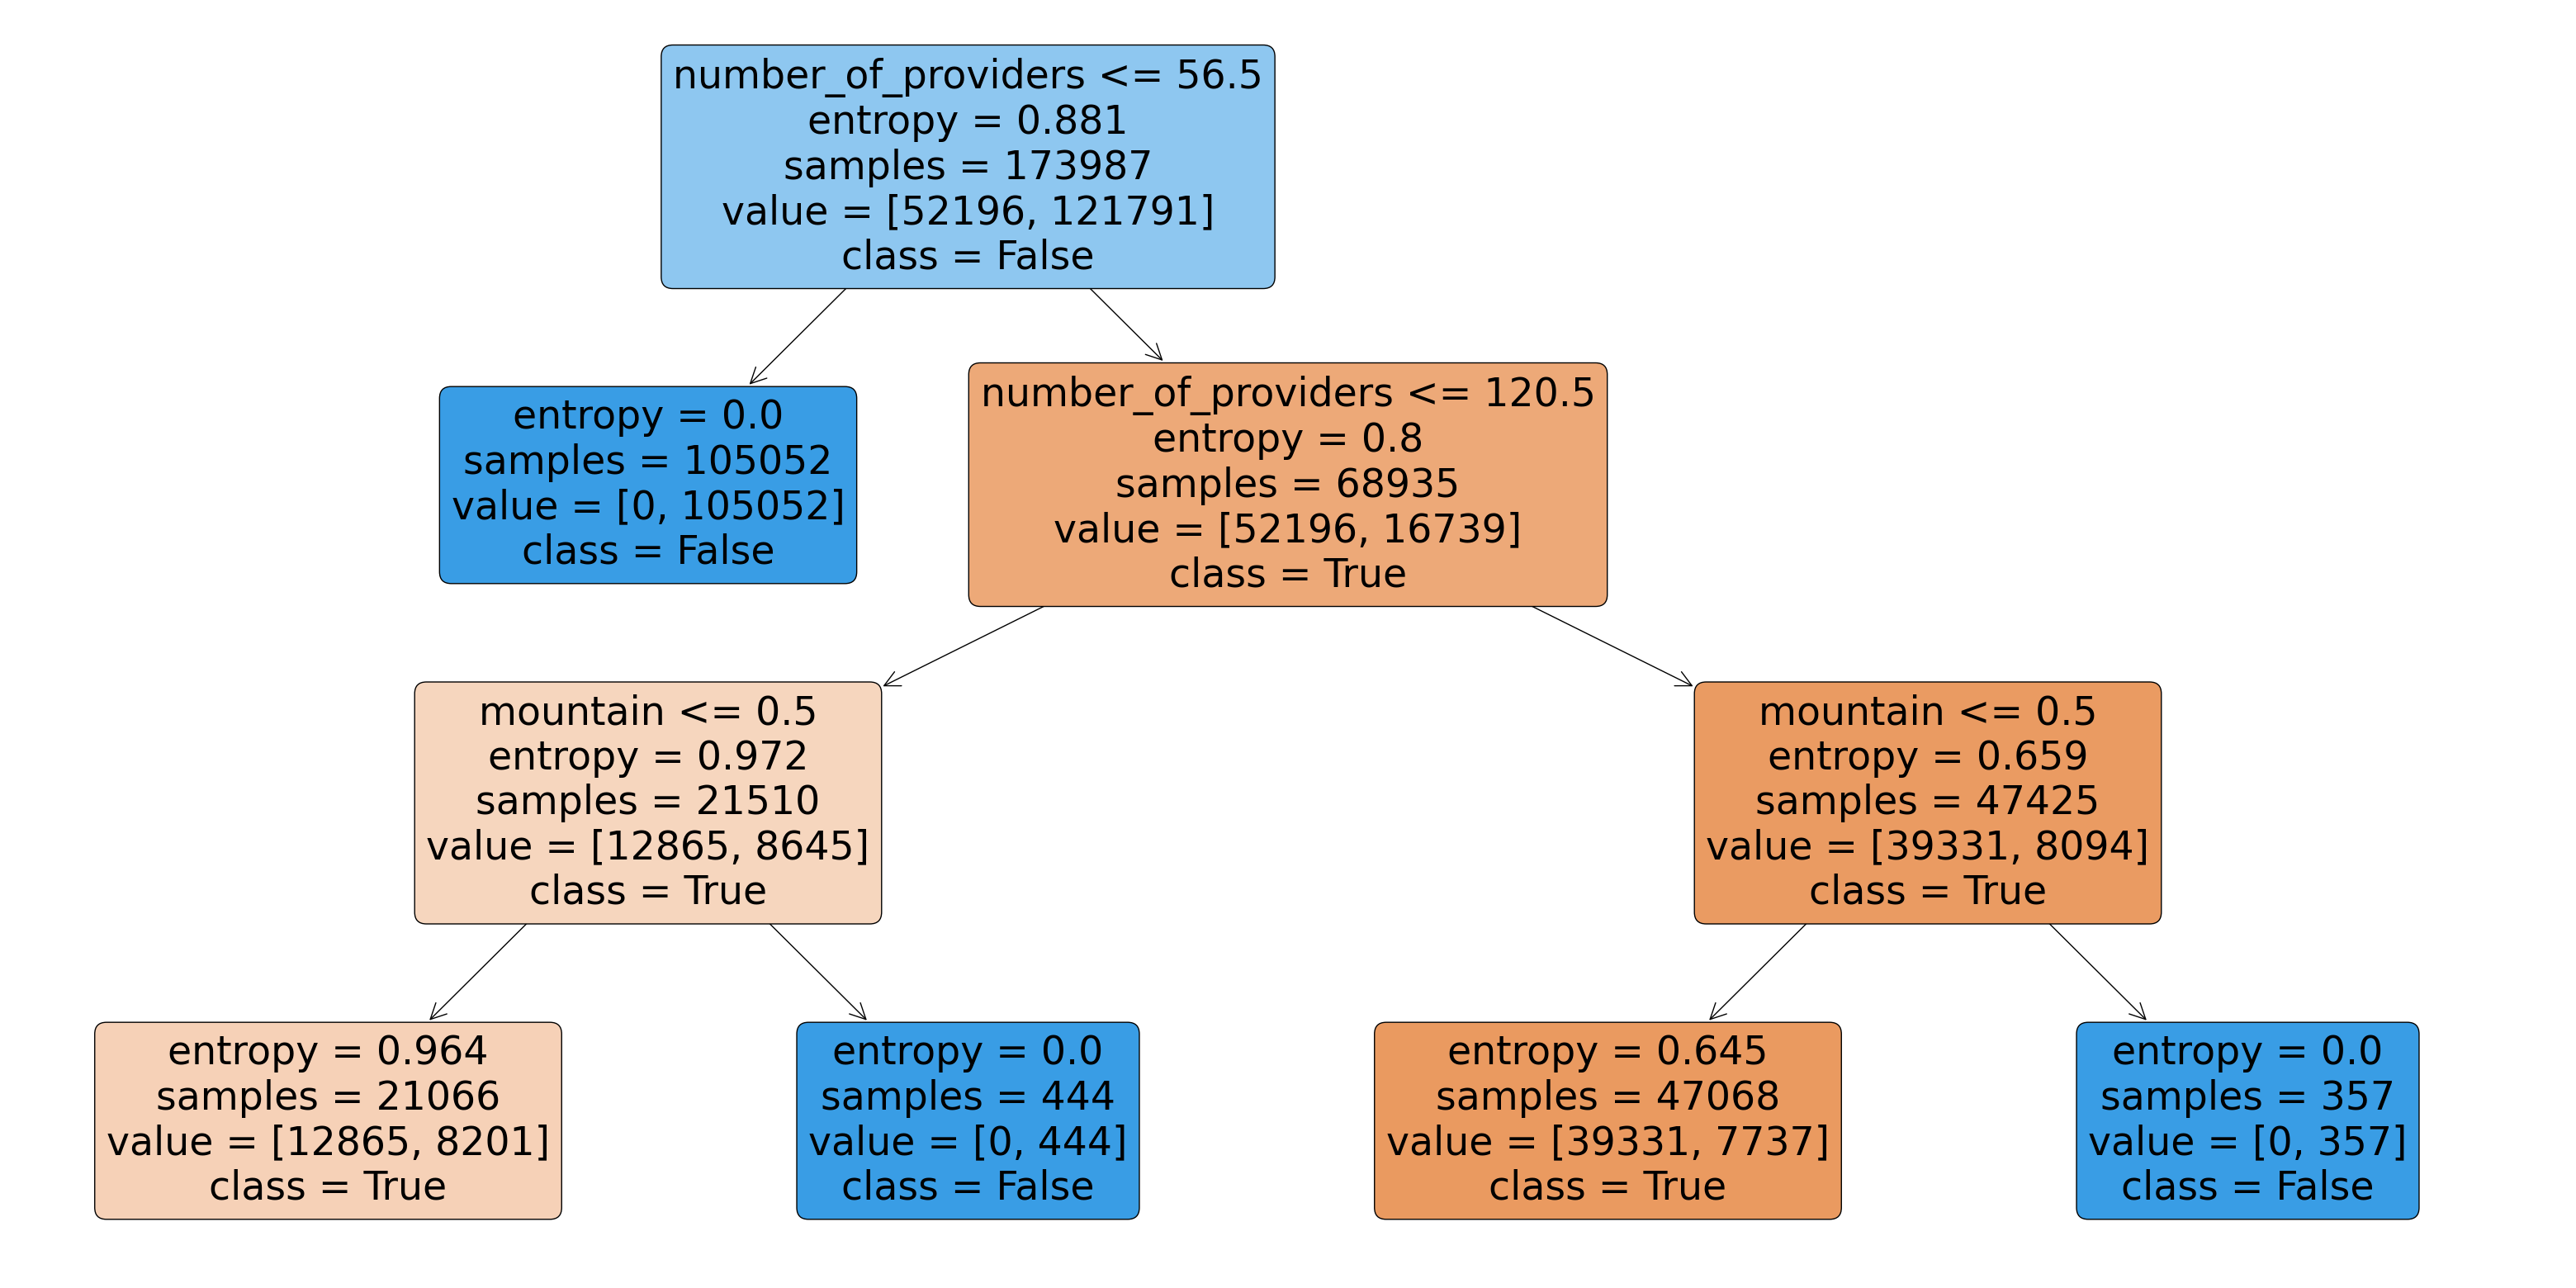

In [56]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(40, 20))
plot_tree(c50_01,
          feature_names=X_test.columns.tolist(),  
          class_names=classes_as_strings,
          filled=True,
          rounded=True)
plt.savefig('plot_C5.png')
plt.show()

A simpler view. The root node of the tree starts off at number providers < 56, representing the dataset

    the splitting critera is entropy which minimizes impurities so that the leaf is at its purest.
    the child node here is clss true because it satisfiees the parent condition <=56.6
    this child ends here because it met the condition by by the parent node, therefore it is false
    this child here is did not satisfy the condition being <120, therefore it is true

    the next classes are both True, satisfying the parent condition.and they are both bountain <=0.5
    

In [57]:
c5_cm =confusion_matrix(y_test, c5_preds)
c5_cm

array([[  116,     0],
       [ 5270, 35326]], dtype=int64)

In [58]:
TN = c5_cm[0][0]
FP = c5_cm[0][1]
FN = c5_cm[1][0]
TP = c5_cm[1][1]

c5_metrics = calculate_metrics("C5", TN, FP, FN, TP)
c5_metrics

,Metric,C5 Values
0,Accuracy,0.870554
1,Error Rate,0.129446
2,Sensitivity,0.870184
3,Specificity,1.000000
4,Precision,1.000000
5,Recall,0.870184
6,F1 Score,0.930587
7,F2 Score,0.893379
8,F0.5 Score,0.971028


The plot shows a high area under the ROC curve (AUC) which indicates that the model performed well at differentiate between the classes across different thresholds. However, it does not outperform the baseline of 99.7%.

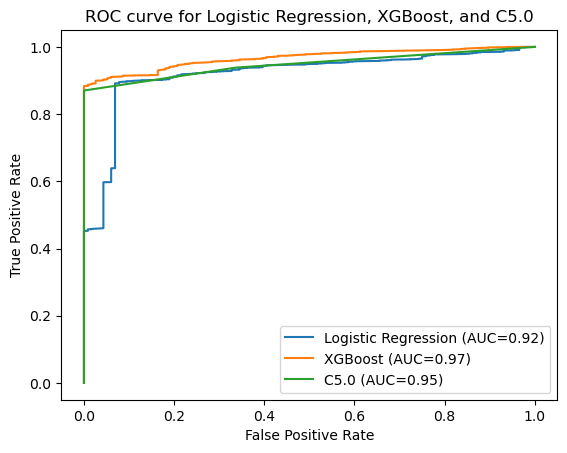

In [59]:
y_pred_proba_c50 = c50_01.predict_proba(X_test)[:, 1]
fpr_c50, tpr_c50, _ = roc_curve(y_test, y_pred_proba_c50)
auc_c50 = roc_auc_score(y_test, y_pred_proba_c50)

# predict and extract column to match
y_pred_proba_logreg = logreg01.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test,  y_pred_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

# predict and extract col
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

# ROC curve for LR, XG, and c5.0
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC={auc_logreg:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={auc_xgb:.2f})")
plt.plot(fpr_c50, tpr_c50, label=f"C5.0 (AUC={auc_c50:.2f})")

plt.title('ROC curve for Logistic Regression, XGBoost, and C5.0')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [60]:
print(classification_report(y_test, logreg01_preds))

              precision    recall  f1-score   support

       False       0.02      0.28      0.04       116
        True       1.00      0.96      0.98     40596

    accuracy                           0.96     40712
   macro avg       0.51      0.62      0.51     40712
weighted avg       1.00      0.96      0.98     40712



In [61]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

       False       0.03      0.82      0.07       116
        True       1.00      0.93      0.97     40596

    accuracy                           0.93     40712
   macro avg       0.52      0.88      0.52     40712
weighted avg       1.00      0.93      0.96     40712



In [62]:
print(classification_report(y_test, c5_preds))

              precision    recall  f1-score   support

       False       0.02      1.00      0.04       116
        True       1.00      0.87      0.93     40596

    accuracy                           0.87     40712
   macro avg       0.51      0.94      0.49     40712
weighted avg       1.00      0.87      0.93     40712

